# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We start with a simple model here:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{cg} & \sim \text{Log-Norm}(0, 1) \\
\alpha & \propto 1 \\
x_{cgs} \mid \beta_{cg} &  \sim \text{Pois}\left(l_{cgs} \cdot \exp \left(\alpha +  \beta_{cg} \right) \right) \\
\end{align}

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated data

In [5]:
seed = 42
np.random.seed(seed)

In [6]:
conditions = ["C" + str(i) for i in range(3)]
genes = ["G" + str(i) for i in range(3)]
sgrnas = ["S" + str(i) for i in range(3)]
replicates = ["R" + str(i) for i in range(5)]

In [91]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [92]:
combinations

[('G0', 'C0', 'S0', 'R0'),
 ('G0', 'C0', 'S0', 'R1'),
 ('G0', 'C0', 'S0', 'R2'),
 ('G0', 'C0', 'S0', 'R3'),
 ('G0', 'C0', 'S0', 'R4'),
 ('G0', 'C0', 'S1', 'R0'),
 ('G0', 'C0', 'S1', 'R1'),
 ('G0', 'C0', 'S1', 'R2'),
 ('G0', 'C0', 'S1', 'R3'),
 ('G0', 'C0', 'S1', 'R4'),
 ('G0', 'C0', 'S2', 'R0'),
 ('G0', 'C0', 'S2', 'R1'),
 ('G0', 'C0', 'S2', 'R2'),
 ('G0', 'C0', 'S2', 'R3'),
 ('G0', 'C0', 'S2', 'R4'),
 ('G0', 'C1', 'S0', 'R0'),
 ('G0', 'C1', 'S0', 'R1'),
 ('G0', 'C1', 'S0', 'R2'),
 ('G0', 'C1', 'S0', 'R3'),
 ('G0', 'C1', 'S0', 'R4'),
 ('G0', 'C1', 'S1', 'R0'),
 ('G0', 'C1', 'S1', 'R1'),
 ('G0', 'C1', 'S1', 'R2'),
 ('G0', 'C1', 'S1', 'R3'),
 ('G0', 'C1', 'S1', 'R4'),
 ('G0', 'C1', 'S2', 'R0'),
 ('G0', 'C1', 'S2', 'R1'),
 ('G0', 'C1', 'S2', 'R2'),
 ('G0', 'C1', 'S2', 'R3'),
 ('G0', 'C1', 'S2', 'R4'),
 ('G0', 'C2', 'S0', 'R0'),
 ('G0', 'C2', 'S0', 'R1'),
 ('G0', 'C2', 'S0', 'R2'),
 ('G0', 'C2', 'S0', 'R3'),
 ('G0', 'C2', 'S0', 'R4'),
 ('G0', 'C2', 'S1', 'R0'),
 ('G0', 'C2', 'S1', 'R1'),
 

In [8]:
count_table = pd.DataFrame(
    combinations, 
    columns=["conditions", "genes", "sgrnas", "replicates"])

In [9]:
tau_true = sp.stats.halfcauchy.rvs(0, 3, size=1)

In [53]:
gamma_true = sp.stats.norm.rvs(0, tau_true, size=len(genes))

In [54]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true = np.repeat(beta_true, len(sgrnas) * len((replicates)))

In [12]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true = np.repeat(l_true, len(replicates))

In [13]:
alpha_true = sp.stats.uniform.rvs(0, 20)

In [14]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [15]:
count_table["counts"] = sp.stats.poisson.rvs(
    l_true * np.exp(alpha_true + beta_true))

Below we test some models and built up this final model recursively.

## Inference in simple model

Let's start with a simple one.

In [ ]:
 gamma_true = sp.stats.norm.rvs(0, tau_true, size=count_table.shape[0])

In [ ]:
count_table["counts"] = sp.stats.poisson.rvs(
    np.exp(alpha_true + gamma_true)
)

In [19]:
conditions_idx = np.repeat(range(len(genes)), len(conditions))
alpha_idx = np.array([0] * count_table.shape[0])
beta_idx = np.repeat(range(len(genes) * len(conditions)), len(sgrnas) * len(replicates))
l_idx = np.repeat(range(len(genes) * len(conditions) * len(sgrnas)), len(replicates))
l_shape =  len(genes) * len(conditions) * len(sgrnas)
tau_b_idx = np.array([0] * len(genes) * len(conditions))

In [20]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=count_table.shape[0])    
    alpha = pm.Uniform('alpha', 0, 20, shape=1)
    x = pm.Poisson(
        'x',         
        mu = np.exp(alpha[alpha_idx] + gamma),            
        observed=count_table["counts"].values)

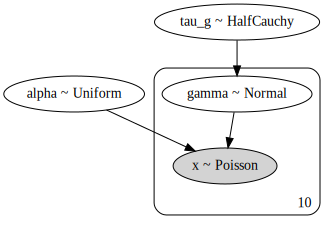

In [21]:
model_to_graphviz(model)

In [22]:
with model:
    trace = pm.sample(5000, n_init=10000,
                      tune=1000, random_seed=seed,
                      init='advi', chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 4,001.7: 100%|██████████| 10000/10000 [00:03<00:00, 2700.81it/s]  
Finished [100%]: Average Loss = 3,933.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:45<00:00, 113.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [24]:
eff_samples = az.effective_sample_size(trace).to_dataframe()

In [25]:
eff_samples = pd.DataFrame({
    'neff': eff_samples[["gamma"]].values[:,0] / 5000,
    'param': ['Gamma' + str(i) for i in range(eff_samples.shape[0])]
})

In [26]:
low_eff_samples = np.where(eff_samples['neff'].values < 0.1)
mid_eff_samples = np.where(
    np.logical_and(eff_samples['neff'].values >= 0.1 , eff_samples['neff'].values < 0.5))
high_eff_samples = np.where(eff_samples['neff'].values >= 0.5)

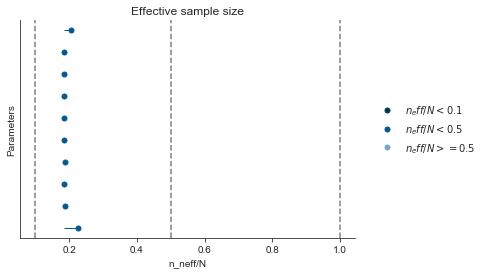

In [27]:
fig = plt.figure()
plt.axvline(x=0.1, color="grey", linestyle="--")
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.axvline(x=1, color="grey", linestyle="--")

plt.hlines(y=eff_samples['param'].values[low_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[low_eff_samples],
           linewidth=1, color='#023858')
plt.hlines(y=eff_samples['param'].values[mid_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[mid_eff_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=eff_samples['param'].values[high_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[high_eff_samples],
           linewidth=1, color='#74a9cf')

plt.plot(eff_samples['neff'].values[low_eff_samples],
         eff_samples['param'].values[low_eff_samples],
         'o', color='#023858', label='$n_eff/N < 0.1$', markersize=5)
plt.plot(eff_samples['neff'].values[mid_eff_samples],
         eff_samples['param'].values[mid_eff_samples], 
         'o', color='#045a8d', label='$n_eff/N < 0.5$', markersize=5)
plt.plot(eff_samples['neff'].values[high_eff_samples], 
         eff_samples['param'].values[high_eff_samples], 
         'o', color='#74a9cf',  label='$n_eff/N >= 0.5$', markersize=5)

plt.title("Effective sample size")
plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel("n_neff/N")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

In [28]:
rhat_samples = az.rhat(trace).to_dataframe()

In [29]:
rhat_samples = pd.DataFrame({
    'rhat': rhat_samples[["gamma"]].values[:,0],
    'param': ['Gamma' + str(i) for i in range(rhat_samples.shape[0])]
})

In [30]:
low_rhat_samples = np.where(rhat_samples['rhat'].values < 1.05)
mid_rhat_samples = np.where(
    np.logical_and(rhat_samples['rhat'].values >= 1.05 , rhat_samples['rhat'].values < 1.1))
high_rhat_samples = np.where(rhat_samples['rhat'].values >= 1.1)

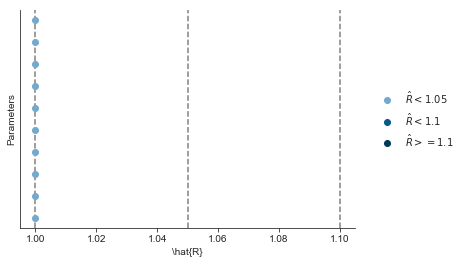

In [31]:
fig = plt.figure()
plt.axvline(x=1.05, color="grey", linestyle="--")
plt.axvline(x=1.1, color="grey", linestyle="--")
plt.axvline(x=np.max(rhat_samples['rhat'].values), color="grey", linestyle="--")

plt.hlines(y=rhat_samples['param'].values[low_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[low_rhat_samples],
           linewidth=1, color='#74a9cf')
plt.hlines(y=rhat_samples['param'].values[mid_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[mid_rhat_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=rhat_samples['param'].values[high_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[high_rhat_samples],
           linewidth=1, color='#023858')

plt.plot(rhat_samples['rhat'].values[low_rhat_samples],
         rhat_samples['param'].values[low_rhat_samples],
         'o', color='#74a9cf', label=r'$\hat{R} < 1.05$')
plt.plot(rhat_samples['rhat'].values[mid_rhat_samples],
         rhat_samples['param'].values[mid_rhat_samples], 
         'o', color='#045a8d', label=r'$\hat{R} < 1.1$')
plt.plot(rhat_samples['rhat'].values[high_rhat_samples], 
         rhat_samples['param'].values[high_rhat_samples], 
         'o', color='#023858',  label='$\hat{R} >= 1.1$')

plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel(r"\hat{R}")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

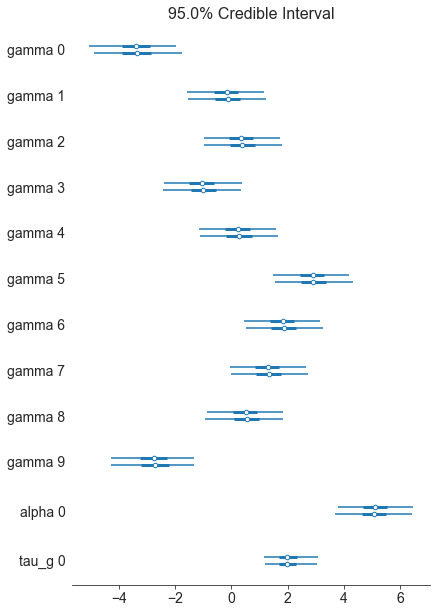

In [32]:
az.plot_forest(trace, credible_interval=0.95);

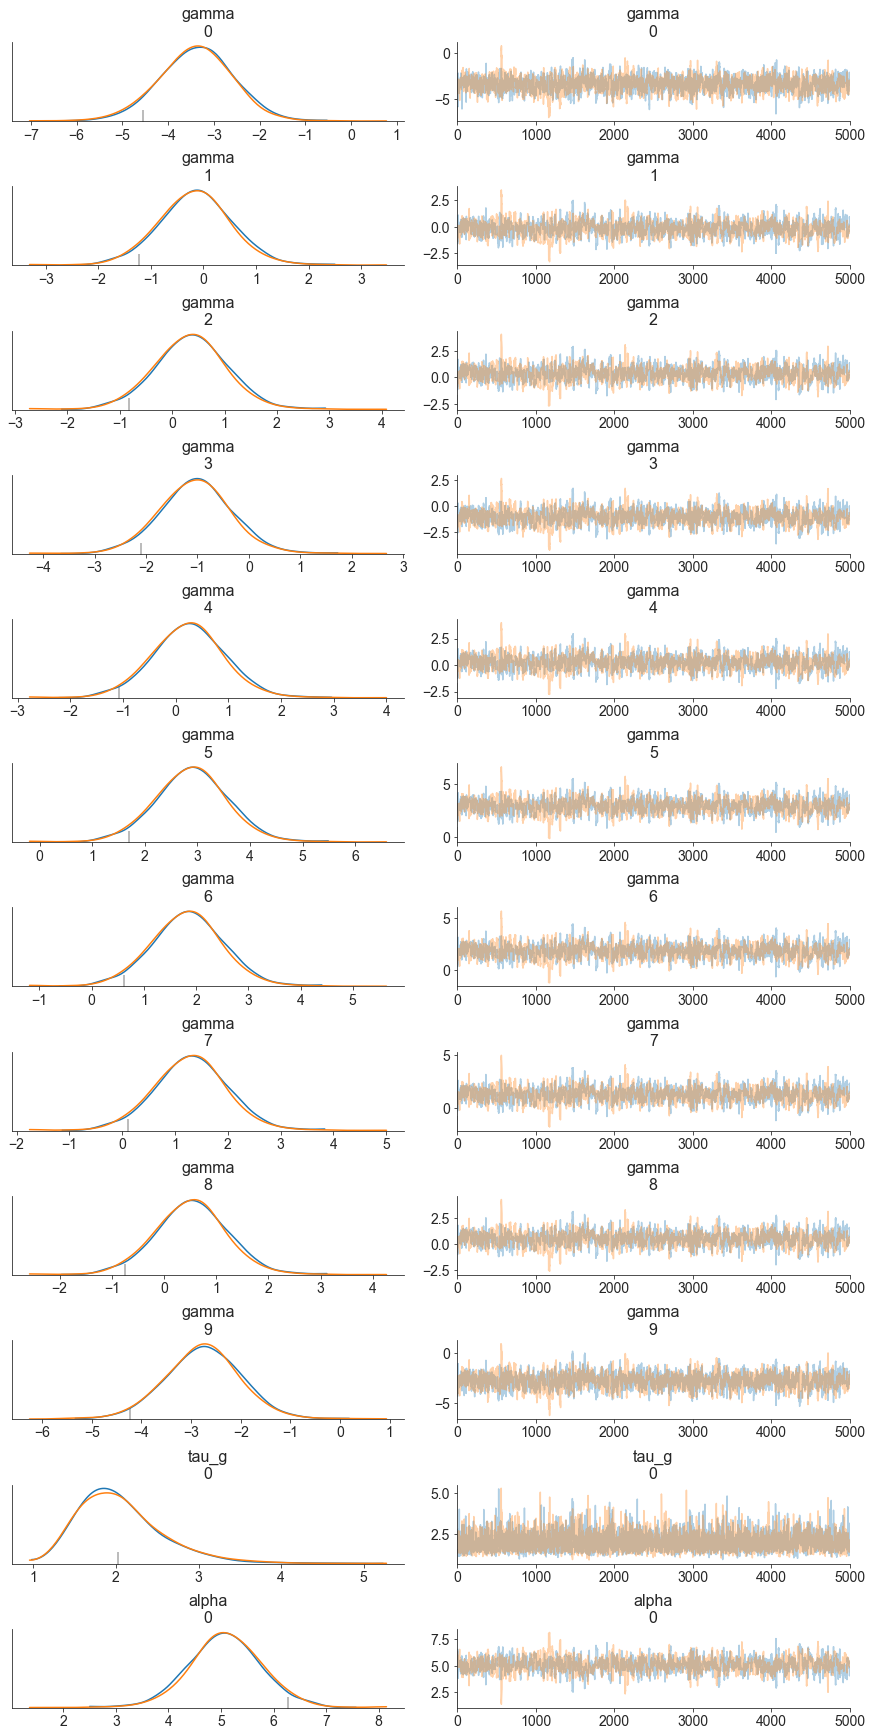

In [34]:
az.plot_trace(trace);

## Inference with a first multi-level

In [60]:
count_table["counts"] = sp.stats.poisson.rvs(
    np.exp(alpha_true + beta_true))

In [86]:
count_table = count_table[["genes", "conditions", "sgrnas", "replicates", "counts"]]

In [88]:
count_table.loc[[0, 15, 30, 45, 60, ],:]

,genes,conditions,sgrnas,replicates,counts
0,0,0,0,0,27560
15,1,0,0,0,32024
30,2,0,0,0,1175
45,0,1,0,0,117
60,1,1,0,0,58


In [63]:
conditions_idx = np.repeat(range(len(genes)), len(conditions))
alpha_idx = np.array([0] * count_table.shape[0])
beta_idx = np.repeat(range(len(genes) * len(conditions)), len(sgrnas) * len(replicates))
tau_b_idx = np.array([0] * len(genes) * len(conditions))

3

In [71]:
conditions_idx

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [ ]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=len(genes))
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta = pm.Normal('beta', gamma[conditions_idx], tau_b[tau_b_idx], shape=9)    
    
    alpha = pm.Uniform('alpha', 0, 20, shape=1)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(alpha[tau_b_idx] + np.exp(beta)),                    
        observed=count_table["counts"].values[:10])